In [40]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, datasets
import os
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
import numpy as np

In [41]:
# 1. Preprocesamiento de Datos
DATASET_PATH = os.path.join('datasets', 'real_and_fake_face')

data_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

full_dataset = datasets.ImageFolder(root=DATASET_PATH, transform=data_transforms)

train_size = int(0.7 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [42]:
# 2. Construcción del Modelo
class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.batch_norm1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.batch_norm2 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64 * 64 * 64, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.batch_norm1(self.conv1(x))))
        x = self.pool(F.relu(self.batch_norm2(self.conv2(x))))
        x = x.flatten(start_dim=1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = CNNClassifier()

In [43]:
# Función de entrenamiento
def train_epoch(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct / total

    return epoch_loss, epoch_accuracy


# 3. Entrenamiento
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = StepLR(optimizer, step_size=5, gamma=0.5)


num_epochs = 15
history_loss = []
history_accuracy = []

for epoch in range(num_epochs):
    train_loss, train_accuracy = train_epoch(model, train_loader, criterion, optimizer)
    scheduler.step()

    history_loss.append(train_loss)
    history_accuracy.append(train_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Accuracy: {train_accuracy * 100:.2f}')



Epoch [1/15], Train Loss: 9.9863, Accuracy: 53.08
Epoch [2/15], Train Loss: 0.7857, Accuracy: 59.87
Epoch [3/15], Train Loss: 0.7296, Accuracy: 60.85
Epoch [4/15], Train Loss: 0.7133, Accuracy: 63.66
Epoch [5/15], Train Loss: 0.6242, Accuracy: 67.79
Epoch [6/15], Train Loss: 0.5949, Accuracy: 68.56
Epoch [7/15], Train Loss: 0.5933, Accuracy: 70.24
Epoch [8/15], Train Loss: 0.5886, Accuracy: 68.42
Epoch [9/15], Train Loss: 0.5733, Accuracy: 70.17
Epoch [10/15], Train Loss: 0.5688, Accuracy: 71.50
Epoch [11/15], Train Loss: 0.5462, Accuracy: 72.48
Epoch [12/15], Train Loss: 0.5341, Accuracy: 72.69
Epoch [13/15], Train Loss: 0.5114, Accuracy: 73.81
Epoch [14/15], Train Loss: 0.5261, Accuracy: 73.67
Epoch [15/15], Train Loss: 0.5209, Accuracy: 73.60


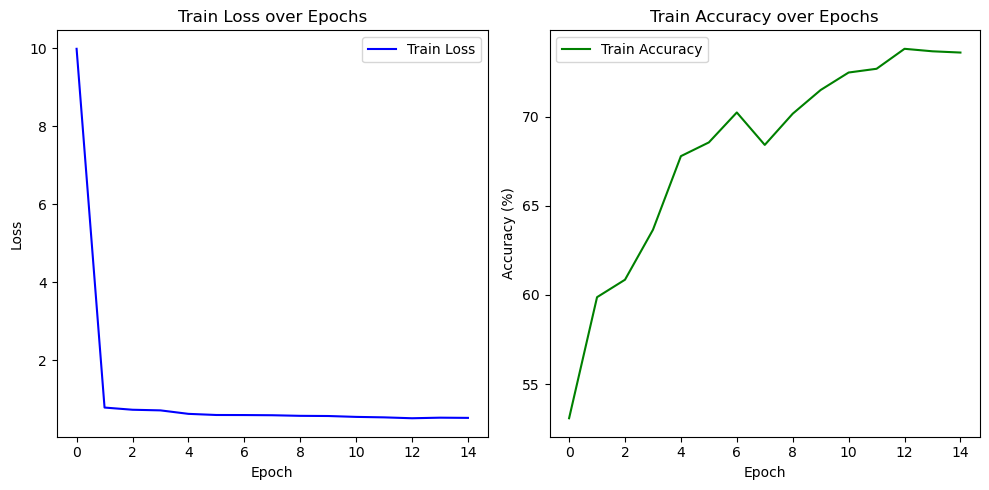

In [44]:
plt.figure(figsize=(10, 5))

# Grafica Loss
plt.subplot(1, 2, 1)
plt.plot(history_loss, label='Train Loss', color='blue')
plt.title('Train Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Grafica Accuracy
plt.subplot(1, 2, 2)
plt.plot([acc * 100 for acc in history_accuracy], label='Train Accuracy', color='green')
plt.title('Train Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.tight_layout()
plt.show()


In [45]:
# 4. Evaluación
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        break

print(f'Accuracy of the model on the test images: {100 * correct / total:.2f} %')


Accuracy of the model on the test images: 56.25 %


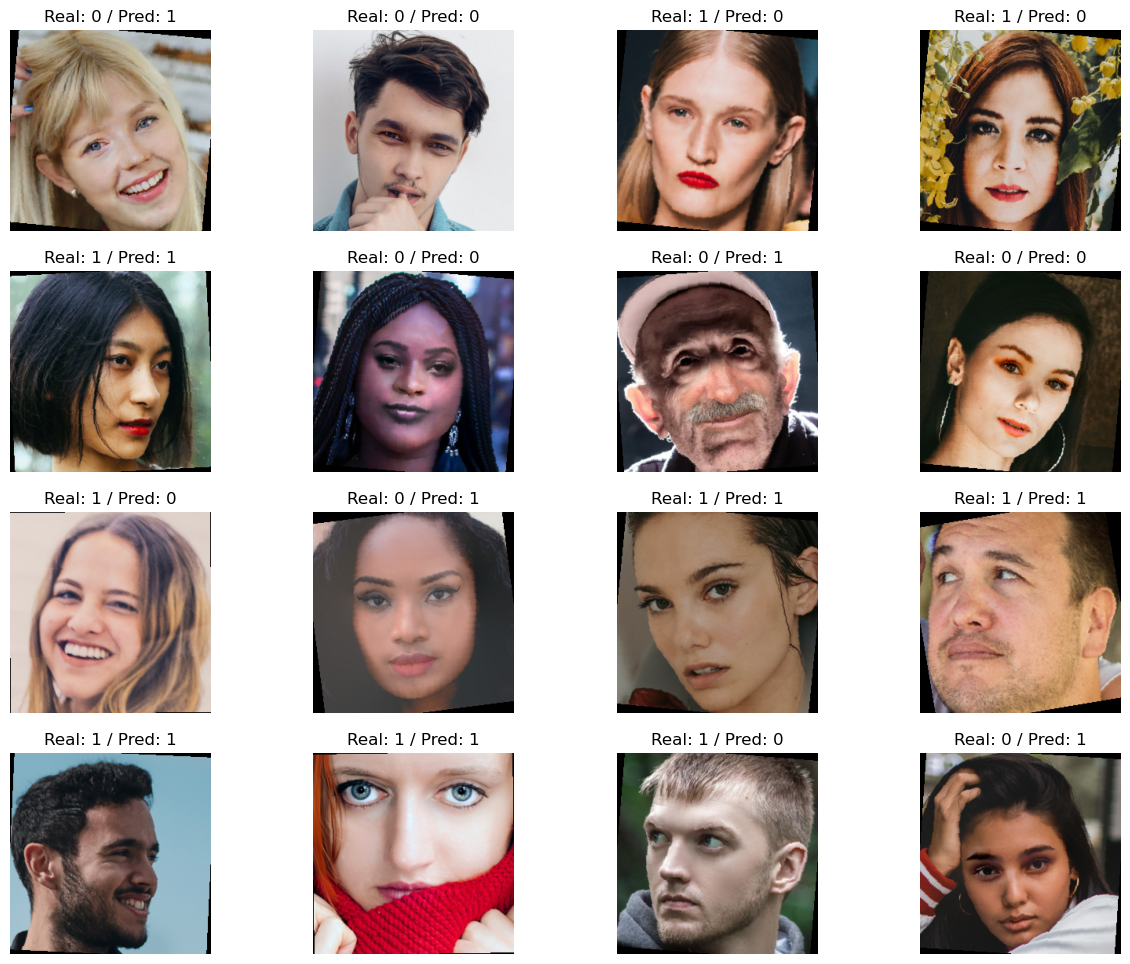

In [46]:
# 5. Visualización

def visualize_predictions(model, test_loader, num_images=5, num_cols=4):
    model.eval()
    images_so_far = 0
    num_rows = int(np.ceil(num_images / num_cols))
    fig, ax = plt.subplots(num_rows, num_cols, figsize=(15, 3 * num_rows))


    inv_normalize = transforms.Normalize(mean=[-1, -1, -1], std=[2, 2, 2])

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                if images_so_far < num_images:
                    row = images_so_far // num_cols
                    col = images_so_far % num_cols

                    img = inv_normalize(inputs[j])
                    ax[row, col].imshow(np.transpose(img.numpy(), (1, 2, 0)))
                    ax[row, col].axis('off')
                    ax[row, col].set_title(f'Real: {labels[j]} / Pred: {preds[j]}')

                    images_so_far += 1

    plt.show()


visualize_predictions(model, test_loader, num_images=16, num_cols=4)



### Prueba con MobileNetV2

In [47]:
# 1. Preprocesamiento de Datos
data_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

full_dataset = datasets.ImageFolder(root=DATASET_PATH, transform=data_transforms)

train_size = int(0.7 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [48]:
# 2. Construcción del Modelo (MobileNetV2)
class MobileNetV2(nn.Module):
    def __init__(self):
        super(MobileNetV2, self).__init__()
        self.mobilenet = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', weights=True)
        self.mobilenet.classifier = nn.Sequential(
            nn.Linear(1280, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 2)
        )

    def forward(self, x):
        return self.mobilenet(x)

In [50]:
#4 Entrenamiento
model = MobileNetV2()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

num_epochs = 15
history_loss = []
history_accuracy = []

for epoch in range(num_epochs):
    train_loss, train_accuracy = train_epoch(model, train_loader, criterion, optimizer)
    scheduler.step()

    history_loss.append(train_loss)
    history_accuracy.append(train_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Accuracy: {train_accuracy * 100:.2f}')


Using cache found in C:\Users\Usuario/.cache\torch\hub\pytorch_vision_v0.10.0


Epoch [1/15], Train Loss: 0.7333, Accuracy: 53.78
Epoch [2/15], Train Loss: 0.6117, Accuracy: 66.95
Epoch [3/15], Train Loss: 0.5836, Accuracy: 70.59
Epoch [4/15], Train Loss: 0.5561, Accuracy: 72.20
Epoch [5/15], Train Loss: 0.5601, Accuracy: 72.20
Epoch [6/15], Train Loss: 0.5100, Accuracy: 77.73
Epoch [7/15], Train Loss: 0.4128, Accuracy: 82.84
Epoch [8/15], Train Loss: 0.3555, Accuracy: 84.94
Epoch [9/15], Train Loss: 0.3135, Accuracy: 86.41
Epoch [10/15], Train Loss: 0.2662, Accuracy: 89.36
Epoch [11/15], Train Loss: 0.2330, Accuracy: 91.18
Epoch [12/15], Train Loss: 0.2088, Accuracy: 93.21
Epoch [13/15], Train Loss: 0.2103, Accuracy: 92.02
Epoch [14/15], Train Loss: 0.1881, Accuracy: 93.56
Epoch [15/15], Train Loss: 0.1922, Accuracy: 93.00


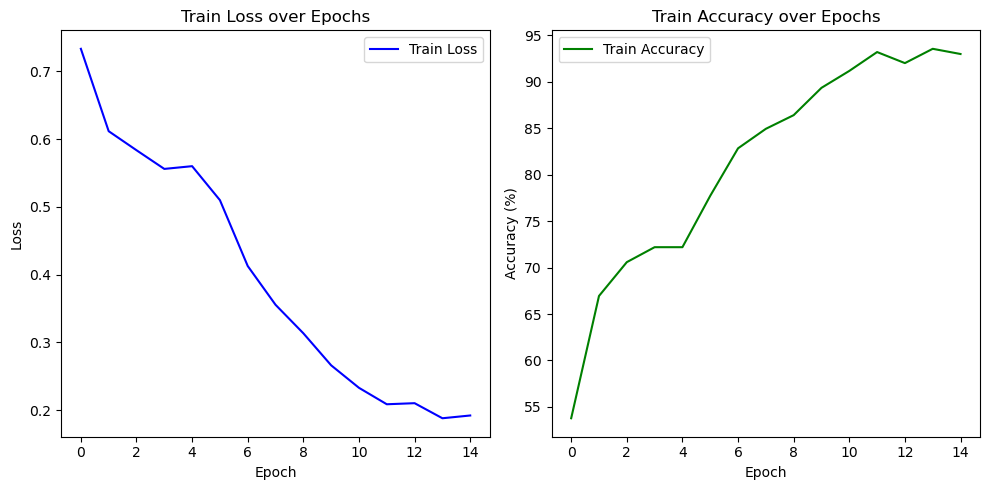

In [51]:
plt.figure(figsize=(10, 5))

# Grafica Loss
plt.subplot(1, 2, 1)
plt.plot(history_loss, label='Train Loss', color='blue')
plt.title('Train Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Grafica Accuracy
plt.subplot(1, 2, 2)
plt.plot([acc * 100 for acc in history_accuracy], label='Train Accuracy', color='green')
plt.title('Train Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.tight_layout()
plt.show()

In [93]:
# 4. Evaluación
model.eval()

correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        break

print(f'Accuracy of the model on the test images: {100 * correct / total:.2f} %')

Accuracy of the model on the test images: 81.25 %


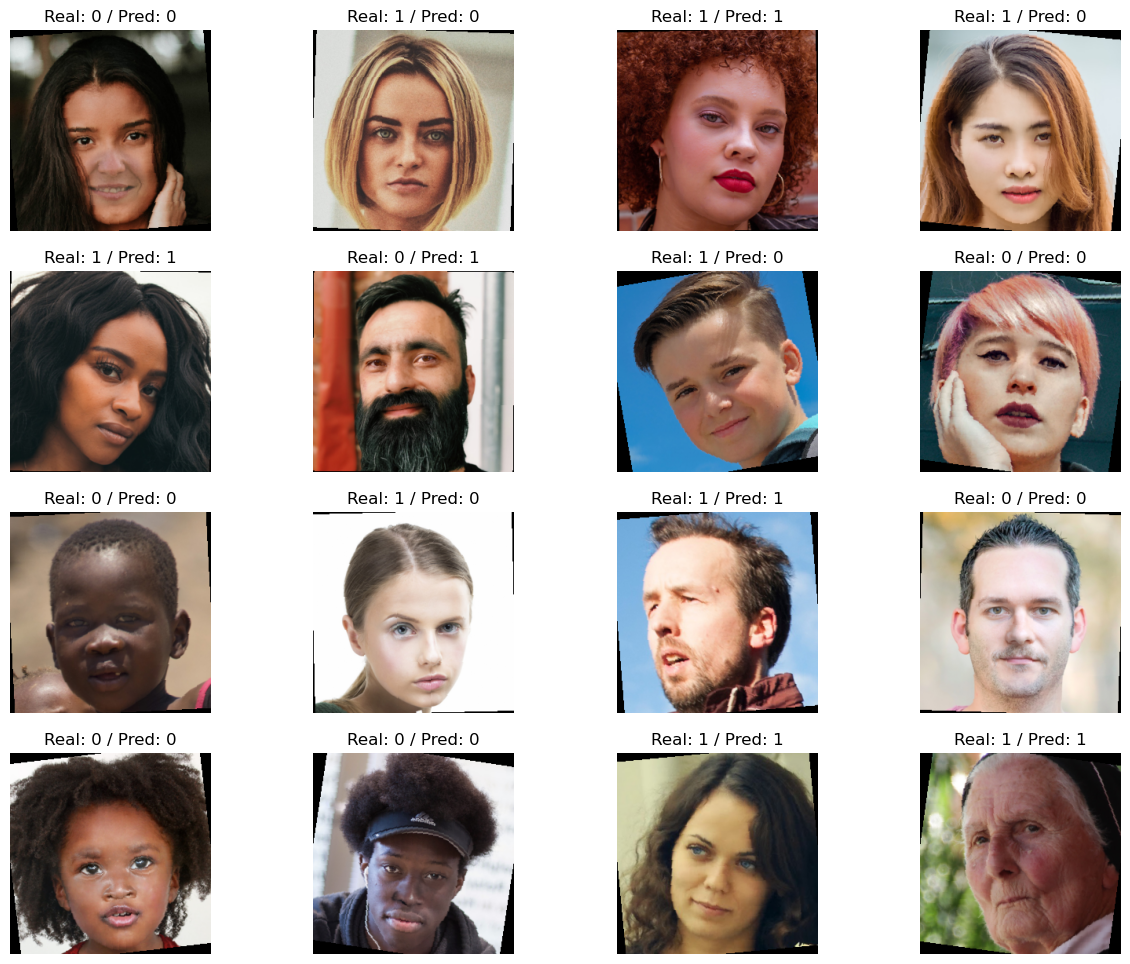

In [95]:
# 5. Visualización
visualize_predictions(model, test_loader, num_images=16, num_cols=4)